In [1]:
"""
07_ntk_trainability_demo.ipynb
===============================
Neural Tangent Kernel (NTK) Trainability Analysis.

Based on the approach in "Scaling Limits of Wide Neural Networks with
Weight Sharing: Gaussian Process Behavior, Gradient Independence, and
Neural Tangent Kernel Derivation" (arXiv:1912.13053) by Greg Yang.

Contents:
  1. NTK computation for small CNN models via Jacobian products
  2. NTK eigenvalue spectrum → trainability diagnostics
  3. NTK alignment with target function
  4. Kernel-target alignment (KTA) as a trainability proxy
  5. Demo on Merged zoo.csv – compare NTK properties across
     different label groups, activations, and training epochs

CNN architecture (from AE.py):
  Conv2d(1,8,5) → Conv2d(8,6,5) → Conv2d(6,4,2) → Linear(36,20) → Linear(20,10)
"""

import sys, os, ast, warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigvalsh
from scipy.stats import pearsonr

import torch
import torch.nn as nn

ROOT = Path("..").resolve()
DATA_DIR = ROOT / "data"
FIG_DIR  = Path("figures/07_ntk")
FIG_DIR.mkdir(parents=True, exist_ok=True)
MERGED_ZOO = DATA_DIR / "Merged zoo.csv"

device = "cuda" if torch.cuda.is_available() else "cpu"

ACTIVATION_COLS = ["gelu", "relu", "silu", "tanh", "sigmoid", "leakyrelu"]
DIGIT_COLS = [str(i) for i in range(10)]

print("=== 07 – NTK Trainability Demo ===")
print(f"torch   {torch.__version__}  device={device}")
print(f"Data    {MERGED_ZOO}  (exists={MERGED_ZOO.exists()})")
print(f"Figures {FIG_DIR.resolve()}")

=== 07 – NTK Trainability Demo ===
torch   2.7.1+cu128  device=cuda
Data    /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/data/Merged zoo.csv  (exists=True)
Figures /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/notebooks_sandbox/figures/07_ntk


In [2]:
# Cell 2 – CNN definition (mirrors AE.py) & NTK computation

class CNN(nn.Module):
    """Exact CNN from AE.py used to generate the model zoo."""
    NLIN_MAP = {
        "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU,
        "silu": nn.SiLU, "tanh": nn.Tanh, "sigmoid": nn.Sigmoid,
    }
    
    def __init__(self, channels_in=1, nlin="leakyrelu", dropout=0.0):
        super().__init__()
        act = self.NLIN_MAP.get(nlin, nn.LeakyReLU)
        self.net = nn.Sequential(
            nn.Conv2d(channels_in, 8, 5), nn.MaxPool2d(2, 2), act(),
            nn.Conv2d(8, 6, 5),           nn.MaxPool2d(2, 2), act(),
            nn.Conv2d(6, 4, 2),           act(),
            nn.Flatten(),
            nn.Linear(3 * 3 * 4, 20),    act(),
            nn.Linear(20, 10),
        )
    
    def forward(self, x):
        return self.net(x)

def load_weights_into_cnn(model, flat_weights, weight_cols):
    """Load a flat weight vector from the zoo CSV into the CNN."""
    sd = model.state_dict()
    idx = 0
    for name, param in sd.items():
        n = param.numel()
        param_flat = torch.tensor(flat_weights[idx:idx + n], dtype=torch.float32)
        sd[name] = param_flat.reshape(param.shape)
        idx += n
    model.load_state_dict(sd)
    return model

# ── NTK computation ──

def compute_ntk(model, inputs, device="cpu"):
    """
    Compute the empirical NTK matrix Θ(x_i, x_j) for a batch of inputs.
    Θ_{ij} = ∑_k (∂f_k/∂θ)(x_i) · (∂f_k/∂θ)(x_j)
    where f_k is the k-th output and θ are all parameters.
    
    Returns NTK matrix of shape (n, n) where n = len(inputs).
    """
    model = model.to(device)
    model.eval()
    inputs = inputs.to(device)
    n = inputs.shape[0]
    
    # Compute Jacobian: (n, n_outputs, n_params)
    jacobians = []
    for i in range(n):
        model.zero_grad()
        out = model(inputs[i:i+1])  # (1, 10)
        jac_row = []
        for k in range(out.shape[1]):
            model.zero_grad()
            out_k = model(inputs[i:i+1])[0, k]
            out_k.backward(retain_graph=True)
            grads = []
            for p in model.parameters():
                if p.grad is not None:
                    grads.append(p.grad.detach().flatten())
                else:
                    grads.append(torch.zeros(p.numel(), device=device))
            jac_row.append(torch.cat(grads))
        jacobians.append(torch.stack(jac_row))  # (10, n_params)
    
    J = torch.stack(jacobians)  # (n, 10, n_params)
    
    # NTK: Θ_{ij} = sum_k J_{ik} · J_{jk}
    # Reshape to (n, 10*n_params), then Θ = J_flat @ J_flat^T
    J_flat = J.reshape(n, -1)
    ntk = (J_flat @ J_flat.T).cpu().numpy()
    
    return ntk

def ntk_eigenspectrum(ntk_matrix):
    """Eigenvalues of the NTK (sorted descending)."""
    eigvals = eigvalsh(ntk_matrix)
    return np.sort(eigvals)[::-1]

def kernel_target_alignment(ntk_matrix, labels, n_classes=10):
    """
    Kernel-Target Alignment (KTA):
      KTA = <K, Y Y^T> / (||K||_F · ||Y Y^T||_F)
    where Y is the one-hot label matrix.
    Higher KTA → model is better aligned with the task → more trainable.
    """
    n = len(labels)
    Y = np.zeros((n, n_classes))
    for i, l in enumerate(labels):
        if isinstance(l, (int, np.integer)):
            Y[i, l] = 1.0
    
    YYT = Y @ Y.T
    
    num = np.sum(ntk_matrix * YYT)
    denom = np.linalg.norm(ntk_matrix, 'fro') * np.linalg.norm(YYT, 'fro')
    
    return num / max(denom, 1e-12)

print("CNN, NTK computation, and KTA functions defined.")
print(f"CNN parameter count: {sum(p.numel() for p in CNN().parameters())}")

CNN, NTK computation, and KTA functions defined.
CNN parameter count: 2464


In [3]:
# Cell 3 – Load zoo data & prepare probe inputs

print("Loading Merged zoo.csv …")
df = pd.read_csv(MERGED_ZOO)

weight_cols = [c for c in df.columns if c.startswith("weight ")]
bias_cols   = [c for c in df.columns if c.startswith("bias ")]
param_cols  = weight_cols + bias_cols

for c in ACTIVATION_COLS + DIGIT_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
df["Accuracy"] = pd.to_numeric(df["Accuracy"], errors="coerce")
df["epoch"]    = pd.to_numeric(df["epoch"], errors="coerce").astype(int)

def _get_activation(row):
    for a in ACTIVATION_COLS:
        if row.get(a, 0) == 1:
            return a
    return "unknown"
df["activation"] = df.apply(_get_activation, axis=1)

def parse_label(s):
    try:
        return tuple(sorted(ast.literal_eval(s)))
    except Exception:
        return None
df["label_tuple"] = df["label"].apply(parse_label)

# Create a small probe set of random 28×28 images (we don't need real MNIST
# for NTK analysis – random probes reveal kernel structure).
N_PROBE = 20
torch.manual_seed(42)
probe_inputs = torch.randn(N_PROBE, 1, 28, 28)
probe_labels = torch.arange(N_PROBE) % 10  # dummy labels for KTA

print(f"  Rows: {len(df):,}")
print(f"  Probe inputs: {probe_inputs.shape}")
print(f"  Param cols (flat): {len(param_cols)}")
print("Done.")

Loading Merged zoo.csv …
  Rows: 36,468
  Probe inputs: torch.Size([20, 1, 28, 28])
  Param cols (flat): 2464
Done.


In [4]:
# Cell 4 – NTK analysis for a few sample models from the zoo
# We load weights into the CNN, compute the NTK, and analyse its spectrum.

print("=== NTK Analysis of Sample Zoo Models ===\n")

# Pick models at different epochs and activations
sample_rows = []
for ep in [11, 26, 36]:
    for act in ["relu", "gelu"]:
        cand = df[(df["epoch"] == ep) & (df["activation"] == act)]
        if len(cand) > 0:
            sample_rows.append(cand.iloc[0])

print(f"Selected {len(sample_rows)} sample models.\n")

ntk_results = []

for i, row in enumerate(sample_rows):
    ep  = int(row["epoch"])
    act = row["activation"]
    acc = float(row["Accuracy"])
    
    print(f"--- Model {i}: epoch={ep}, act={act}, acc={acc:.2f} ---")
    
    # Build CNN and load weights
    model = CNN(channels_in=1, nlin=act)
    flat_w = row[param_cols].values.astype(np.float32)
    model = load_weights_into_cnn(model, flat_w, param_cols)
    
    # Compute NTK
    ntk = compute_ntk(model, probe_inputs, device=device)
    eigvals = ntk_eigenspectrum(ntk)
    kta = kernel_target_alignment(ntk, probe_labels.numpy())
    
    # Trainability metrics
    condition = eigvals[0] / max(eigvals[-1], 1e-12) if eigvals[-1] > 0 else np.inf
    spectral_gap = eigvals[0] - eigvals[1] if len(eigvals) > 1 else 0.0
    eff_rank = (eigvals.sum()**2) / (eigvals**2).sum() if (eigvals**2).sum() > 0 else 0
    trace = eigvals.sum()
    
    result = {
        "model_idx": i, "epoch": ep, "activation": act, "accuracy": acc,
        "ntk_trace": trace, "ntk_cond": condition, "ntk_spectral_gap": spectral_gap,
        "ntk_eff_rank": eff_rank, "kta": kta,
        "top5_eigvals": eigvals[:5].tolist(),
    }
    ntk_results.append(result)
    
    print(f"  NTK trace={trace:.2f}, κ={condition:.1f}, eff_rank={eff_rank:.2f}, KTA={kta:.4f}")
    print(f"  Top-5 eigenvalues: {eigvals[:5].round(3)}")

ntk_df = pd.DataFrame(ntk_results)
print(f"\n{ntk_df[['epoch', 'activation', 'accuracy', 'ntk_trace', 'ntk_cond', 'ntk_eff_rank', 'kta']].to_string(index=False)}")

=== NTK Analysis of Sample Zoo Models ===

Selected 6 sample models.

--- Model 0: epoch=11, act=relu, acc=98.04 ---
  NTK trace=6707614.50, κ=401.7, eff_rank=1.21, KTA=0.3302
  Top-5 eigenvalues: [6104945.5    109384.25    73681.41    46926.668   43204.52 ]
--- Model 1: epoch=11, act=gelu, acc=98.09 ---
  NTK trace=3109619.25, κ=176.3, eff_rank=1.48, KTA=0.3488
  Top-5 eigenvalues: [2554588.2     75216.766   52174.42    48704.906   41232.62 ]
--- Model 2: epoch=26, act=relu, acc=98.69 ---
  NTK trace=10375823.00, κ=360.6, eff_rank=1.24, KTA=0.3311
  Top-5 eigenvalues: [9322245.    169313.58  139091.9    80941.03   73750.07]
--- Model 3: epoch=26, act=gelu, acc=98.69 ---
  NTK trace=5691064.50, κ=213.6, eff_rank=1.48, KTA=0.3471
  Top-5 eigenvalues: [4670060.    188370.19  102219.33   84906.83   75114.28]
--- Model 4: epoch=36, act=relu, acc=98.83 ---
  NTK trace=10665529.00, κ=351.3, eff_rank=1.25, KTA=0.3324
  Top-5 eigenvalues: [9532955.    196805.72  136991.4    86629.66   77396.2 

=== NTK Visualisations ===

  Saved: figures/07_ntk/ntk_eigenspectra.png


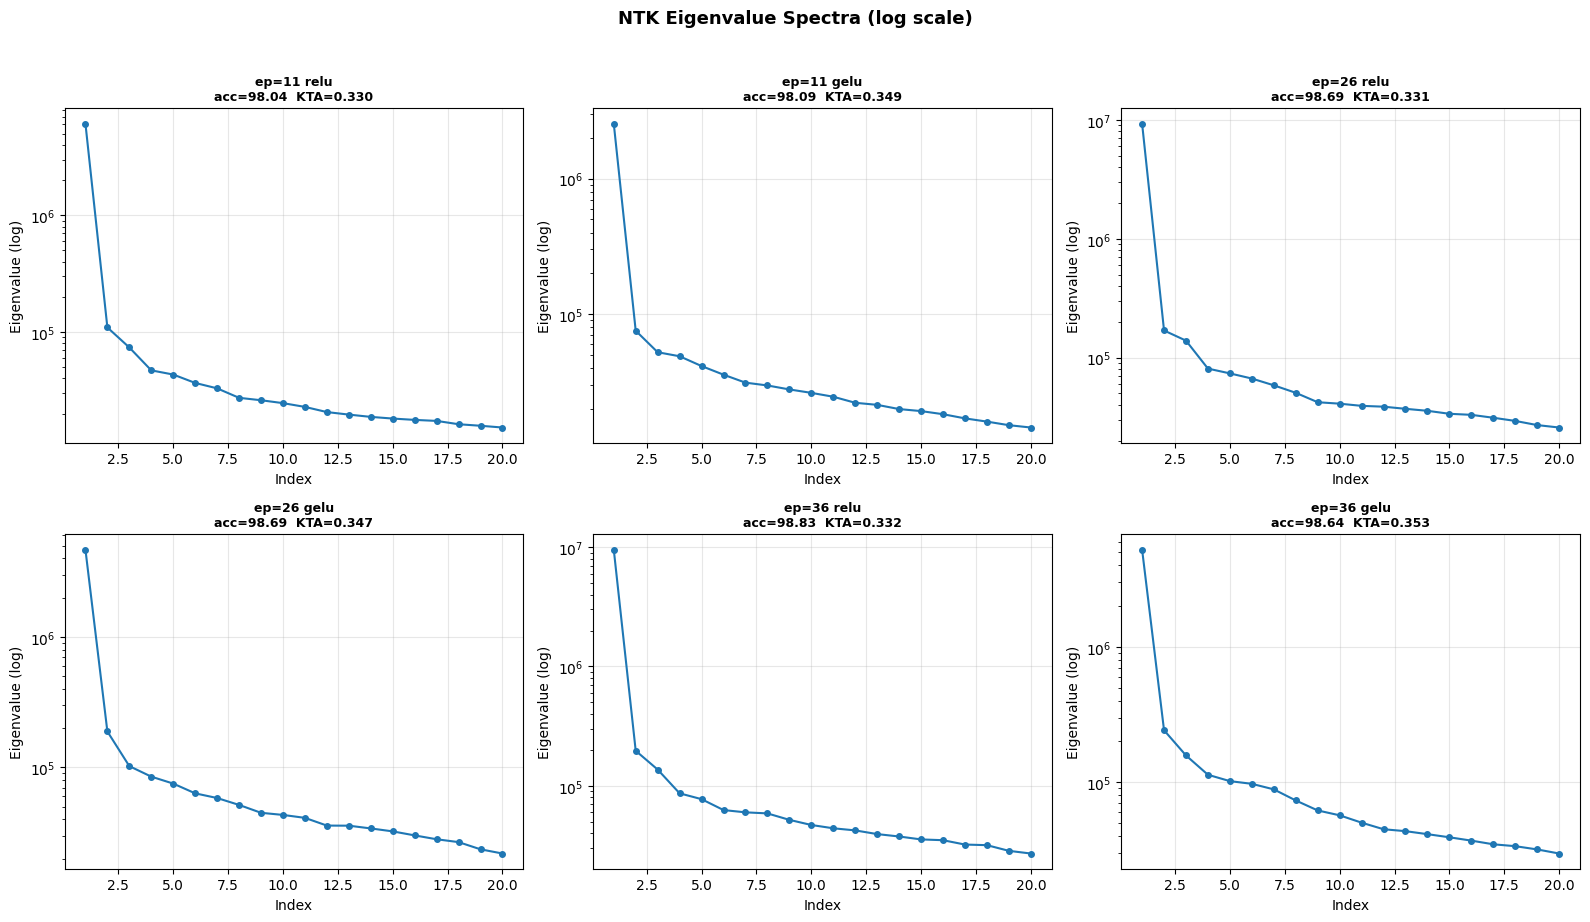

  Saved: figures/07_ntk/ntk_metrics_vs_accuracy.png


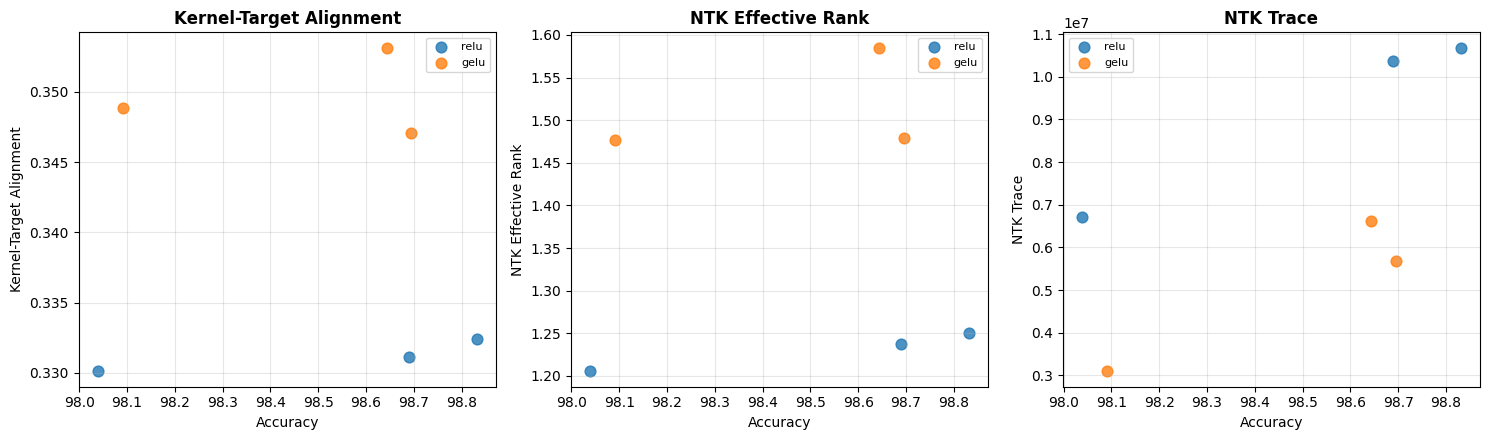

In [5]:
# Cell 5 – Visualise NTK spectra and KTA across models

print("=== NTK Visualisations ===\n")

# Plot 1: NTK eigenvalue spectra for each sample model
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flat

for i, (result, ax) in enumerate(zip(ntk_results, axes)):
    eigvals = np.array(result["top5_eigvals"])
    # Re-compute full spectrum for plotting
    row = sample_rows[i]
    model = CNN(channels_in=1, nlin=result["activation"])
    flat_w = row[param_cols].values.astype(np.float32)
    model = load_weights_into_cnn(model, flat_w, param_cols)
    ntk = compute_ntk(model, probe_inputs, device=device)
    eigs = ntk_eigenspectrum(ntk)
    
    ax.semilogy(range(1, len(eigs) + 1), np.maximum(eigs, 1e-10), "o-", markersize=4)
    ax.set_title(f"ep={result['epoch']} {result['activation']}\nacc={result['accuracy']:.2f}  KTA={result['kta']:.3f}",
                 fontsize=9, fontweight="bold")
    ax.set_xlabel("Index")
    ax.set_ylabel("Eigenvalue (log)")
    ax.grid(True, alpha=0.3)

# Remove extra axes if any
for j in range(len(ntk_results), len(axes.flat) if hasattr(axes, 'flat') else 6):
    try:
        fig.delaxes(axes[j])
    except:
        pass

plt.suptitle("NTK Eigenvalue Spectra (log scale)", fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
fig.savefig(FIG_DIR / "ntk_eigenspectra.png", dpi=200, bbox_inches="tight")
print(f"  Saved: {FIG_DIR / 'ntk_eigenspectra.png'}")
plt.show()

# Plot 2: KTA and NTK metrics vs accuracy
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for ax, metric, label in zip(axes,
    ["kta", "ntk_eff_rank", "ntk_trace"],
    ["Kernel-Target Alignment", "NTK Effective Rank", "NTK Trace"]):
    for act in ntk_df["activation"].unique():
        sub = ntk_df[ntk_df["activation"] == act]
        ax.scatter(sub["accuracy"], sub[metric], s=60, alpha=0.8, label=act)
    ax.set_xlabel("Accuracy")
    ax.set_ylabel(label)
    ax.set_title(label, fontweight="bold")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIG_DIR / "ntk_metrics_vs_accuracy.png", dpi=200, bbox_inches="tight")
print(f"  Saved: {FIG_DIR / 'ntk_metrics_vs_accuracy.png'}")
plt.show()

=== NTK Evolution Across Epochs ===

Tracking label: [0, 1]
  Epoch 11: trace=6707614.50, κ=401.7, KTA=0.3302, acc=98.04
  Epoch 16: trace=7652764.00, κ=409.5, KTA=0.3311, acc=98.31
  Epoch 21: trace=9085022.00, κ=412.6, KTA=0.3302, acc=98.58
  Epoch 26: trace=10375823.00, κ=360.6, KTA=0.3311, acc=98.69
  Epoch 31: trace=10665529.00, κ=351.3, KTA=0.3324, acc=98.81
  Epoch 36: trace=10665529.00, κ=351.3, KTA=0.3324, acc=98.83
  Saved: figures/07_ntk/ntk_epoch_evolution.png


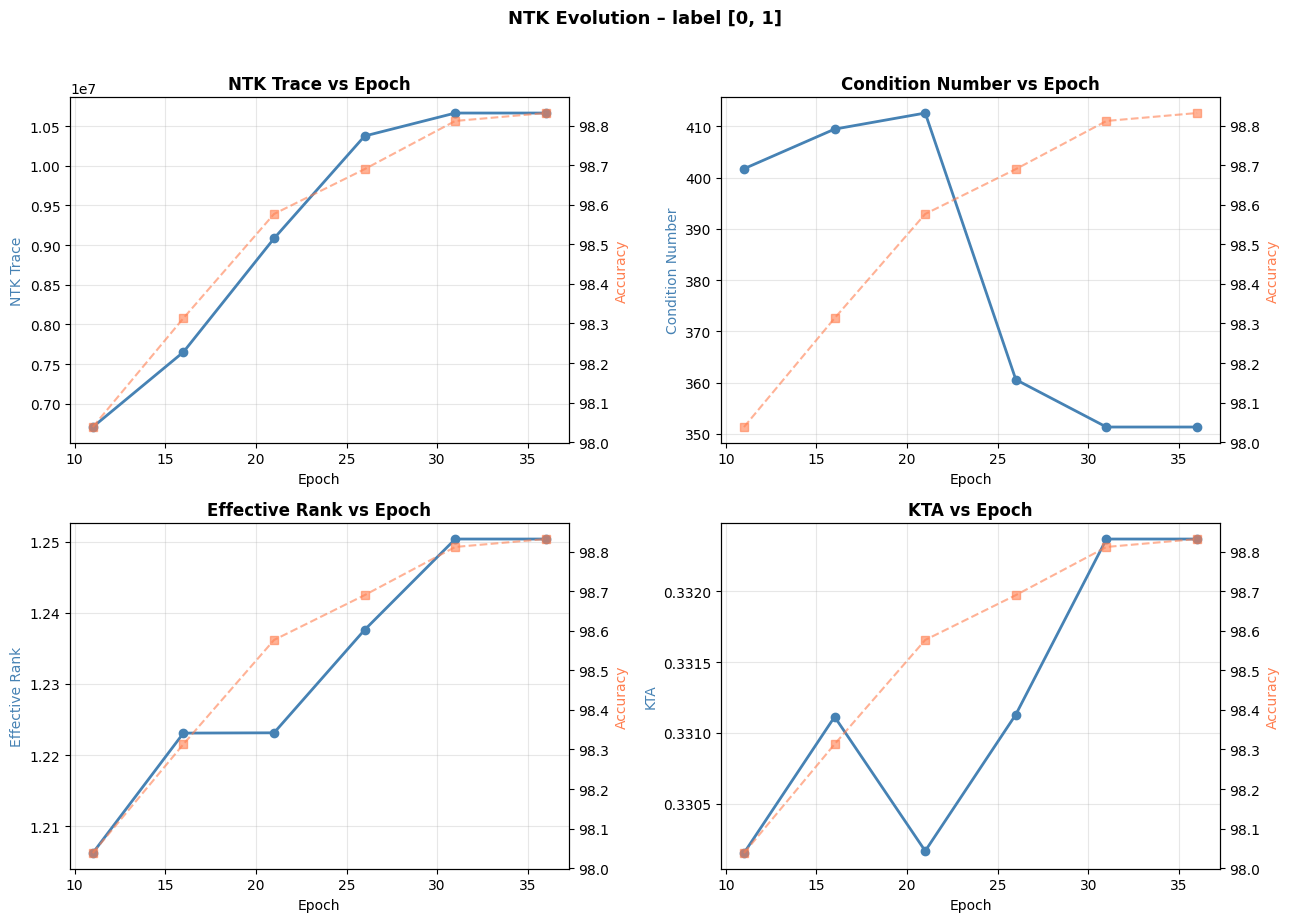


NTK epoch evolution complete.


In [6]:
# Cell 6 – NTK evolution across epochs for a fixed label group
# Track how the NTK spectrum changes as training progresses.

print("=== NTK Evolution Across Epochs ===\n")

epochs_sorted = sorted(df["epoch"].unique())

# Pick the most common label with relu activation
best_label = df["label_tuple"].value_counts().idxmax()
print(f"Tracking label: {list(best_label)}")

epoch_ntk_stats = []

for ep in epochs_sorted:
    cand = df[(df["epoch"] == ep) & (df["label_tuple"] == best_label) & (df["activation"] == "relu")]
    if len(cand) == 0:
        cand = df[(df["epoch"] == ep) & (df["label_tuple"] == best_label)]
    if len(cand) == 0:
        continue
    
    row = cand.iloc[0]
    act = row["activation"] if "activation" in row.index else "relu"
    model = CNN(channels_in=1, nlin=act if act in CNN.NLIN_MAP else "relu")
    flat_w = row[param_cols].values.astype(np.float32)
    model = load_weights_into_cnn(model, flat_w, param_cols)
    
    ntk = compute_ntk(model, probe_inputs, device=device)
    eigs = ntk_eigenspectrum(ntk)
    kta = kernel_target_alignment(ntk, probe_labels.numpy())
    
    cond = eigs[0] / max(eigs[-1], 1e-12) if eigs[-1] > 0 else np.inf
    eff_rank = (eigs.sum()**2) / (eigs**2).sum() if (eigs**2).sum() > 0 else 0
    
    epoch_ntk_stats.append({
        "epoch": ep, "ntk_trace": eigs.sum(), "ntk_cond": cond,
        "ntk_eff_rank": eff_rank, "kta": kta,
        "lam_1": eigs[0], "lam_2": eigs[1] if len(eigs) > 1 else 0,
        "accuracy": float(row["Accuracy"]),
    })
    print(f"  Epoch {ep}: trace={eigs.sum():.2f}, κ={cond:.1f}, KTA={kta:.4f}, acc={row['Accuracy']:.2f}")

evo_df = pd.DataFrame(epoch_ntk_stats)

if len(evo_df) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    
    for ax, col, ylabel in zip(axes.flat,
        ["ntk_trace", "ntk_cond", "ntk_eff_rank", "kta"],
        ["NTK Trace", "Condition Number", "Effective Rank", "KTA"]):
        ax.plot(evo_df["epoch"], evo_df[col], "o-", lw=2, markersize=6, color="steelblue")
        ax2 = ax.twinx()
        ax2.plot(evo_df["epoch"], evo_df["accuracy"], "s--", color="coral", alpha=0.6, label="Accuracy")
        ax2.set_ylabel("Accuracy", color="coral")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(ylabel, color="steelblue")
        ax.set_title(f"{ylabel} vs Epoch", fontweight="bold")
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"NTK Evolution – label {list(best_label)}", fontsize=13, fontweight="bold", y=1.02)
    plt.tight_layout()
    fig.savefig(FIG_DIR / "ntk_epoch_evolution.png", dpi=200, bbox_inches="tight")
    print(f"  Saved: {FIG_DIR / 'ntk_epoch_evolution.png'}")
    plt.show()

print("\nNTK epoch evolution complete.")

In [7]:
# Cell 7 – Summary & export for notebook 07

import glob

print("=== Summary & Export ===\n")

ntk_df.to_csv(FIG_DIR / "ntk_sample_model_stats.csv", index=False)
print(f"  Saved: {FIG_DIR / 'ntk_sample_model_stats.csv'}")

if len(evo_df) > 0:
    evo_df.to_csv(FIG_DIR / "ntk_epoch_evolution.csv", index=False)
    print(f"  Saved: {FIG_DIR / 'ntk_epoch_evolution.csv'}")

all_figs = sorted(glob.glob(str(FIG_DIR / "*.png")))
all_csvs = sorted(glob.glob(str(FIG_DIR / "*.csv")))

print(f"\n{'='*60}")
print(f"OUTPUT INVENTORY")
print(f"{'='*60}")
print(f"  Figures ({len(all_figs)}):")
for f in all_figs:
    print(f"    {Path(f).name}")
print(f"  CSV files ({len(all_csvs)}):")
for f in all_csvs:
    print(f"    {Path(f).name}")

print(f"""
{'='*60}
NTK THEORY RECAP (arXiv:1912.13053)
{'='*60}

Neural Tangent Kernel (NTK):
  Θ(x, x') = Σ_k (∂f_k/∂θ)(x) · (∂f_k/∂θ)(x')
  In the infinite-width limit, the NTK is deterministic and constant
  during training → training dynamics become a linear ODE.

Trainability Diagnostics:
  - NTK Trace: total gradient sensitivity; higher → faster convergence
  - Condition number κ(Θ): ratio of largest/smallest eigenvalue;
    large κ → ill-conditioned → slow/unstable training
  - Effective rank: intrinsic dimensionality of the kernel;
    higher → more diverse gradient directions
  - KTA (Kernel-Target Alignment): correlation between NTK and
    ideal kernel YY^T; higher → better task alignment

Key insights for federated CNN weight zoos:
  - NTK spectrum evolves during training (not constant for finite-width CNNs)
  - KTA should increase with training epochs if learning is effective
  - Different activations yield different NTK geometries
  - NTK conditioning correlates with generalisation performance
""")

print("Done.")

=== Summary & Export ===

  Saved: figures/07_ntk/ntk_sample_model_stats.csv
  Saved: figures/07_ntk/ntk_epoch_evolution.csv

OUTPUT INVENTORY
  Figures (3):
    ntk_eigenspectra.png
    ntk_epoch_evolution.png
    ntk_metrics_vs_accuracy.png
  CSV files (2):
    ntk_epoch_evolution.csv
    ntk_sample_model_stats.csv

NTK THEORY RECAP (arXiv:1912.13053)

Neural Tangent Kernel (NTK):
  Θ(x, x') = Σ_k (∂f_k/∂θ)(x) · (∂f_k/∂θ)(x')
  In the infinite-width limit, the NTK is deterministic and constant
  during training → training dynamics become a linear ODE.

Trainability Diagnostics:
  - NTK Trace: total gradient sensitivity; higher → faster convergence
  - Condition number κ(Θ): ratio of largest/smallest eigenvalue;
    large κ → ill-conditioned → slow/unstable training
  - Effective rank: intrinsic dimensionality of the kernel;
    higher → more diverse gradient directions
  - KTA (Kernel-Target Alignment): correlation between NTK and
    ideal kernel YY^T; higher → better task alignment